
# Image denoising using dictionary learning

The dictionary is fitted on the distorted left half of the image, and
subsequently used to reconstruct the right half. Note that even better
performance could be achieved by fitting to an undistorted (i.e.
noiseless) image, but here we start from the assumption that it is not
available.

A common practice for evaluating the results of image denoising is by looking
at the difference between the reconstruction and the original image. If the
reconstruction is perfect this will look like Gaussian noise.

It can be seen from the plots that the results of `omp` with two
non-zero coefficients is a bit less biased than when keeping only one
(the edges look less prominent). It is in addition closer from the ground
truth in Frobenius norm.

The result of `least_angle_regression` is much more strongly biased: the
difference is reminiscent of the local intensity value of the original image.

Thresholding is clearly not useful for denoising, but it is here to show that
it can produce a suggestive output with very high speed, and thus be useful
for other tasks such as object classification, where performance is not
necessarily related to visualisation.


## Generate distorted image



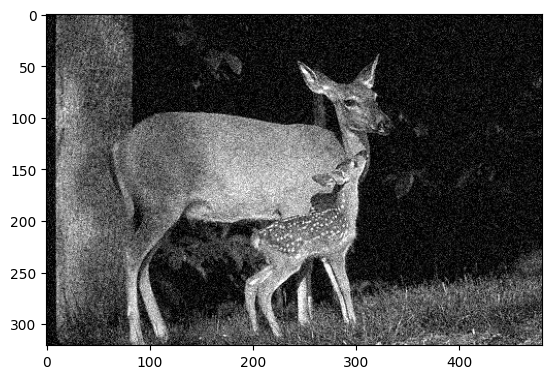

In [1]:
import numpy as np
import cv2
from skimage.util.shape import view_as_blocks
import matplotlib.pyplot as plt
from utils import extract_blocks, generate_data, show_with_diff, reconstruct_image_from_patches
from sklearn.decomposition import MiniBatchDictionaryLearning
import matplotlib.pyplot as plt
from time import time
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
from skimage.util.shape import view_as_blocks
from PIL import Image

original = cv2.imread("Figures/image2.jpg", cv2.IMREAD_GRAYSCALE)
distorted = cv2.imread("Figures/noisy_image0_noise_lvl25.jpg", cv2.IMREAD_GRAYSCALE)

height, width = distorted.shape 

f = plt.figure()
plt.imshow(distorted,cmap='gray')

## Display the distorted image



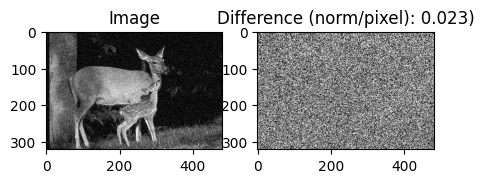

In [2]:
show_with_diff(distorted, original, "")

## Extract reference patches



In [3]:
# Extract all reference patches from the left half of the image
print("Extracting reference patches...")
t0 = time()
patch_size = (8, 8)
data = extract_patches_2d(distorted, patch_size)
data = data.astype(np.float64)
data = data.reshape(data.shape[0], -1)
data -= np.mean(data, axis=0)
data /= np.std(data, axis=0)
print(f"{data.shape[0]} patches extracted in %.2fs." % (time() - t0))

Extracting reference patches...
148836 patches extracted in 0.09s.


## Extract a subset of the patches

In [4]:
dictionary_size = 4000
data = generate_data(distorted, dictionary_size)

## Learn the dictionary from reference patches



Learning the dictionary...
(256, 64)


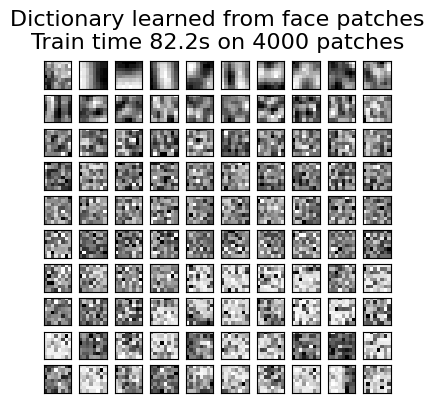

In [5]:
print("Learning the dictionary...")
t0 = time()
dico = MiniBatchDictionaryLearning(
    # increase to 300 for higher quality results at the cost of slower
    # training times.
    n_components=256,
    batch_size=200,
    alpha=1.0,
    max_iter=10,
)
V = dico.fit(data).components_
dt = time() - t0
print(V.shape)
plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(V[:100]):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape(patch_size), cmap=plt.cm.gray_r, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())
plt.suptitle(
    "Dictionary learned from face patches\n"
    + "Train time %.1fs on %d patches" % (dt, len(data)),
    fontsize=16,
)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

## Extract noisy patches and reconstruct them using the dictionary



Extracting noisy patches... 
done in 0.04s.
Orthogonal Matching Pursuit
2 atom...
done in %.2fs. RMSE: 13.3043, PSNR: 25.6510 dB
done in 17.66s.
Orthogonal Matching Pursuit
8 atoms...
done in %.2fs. RMSE: 13.7207, PSNR: 25.3833 dB
done in 45.78s.
Orthogonal Matching Pursuit
16 atoms...
done in %.2fs. RMSE: 17.5137, PSNR: 23.2632 dB
done in 57.32s.


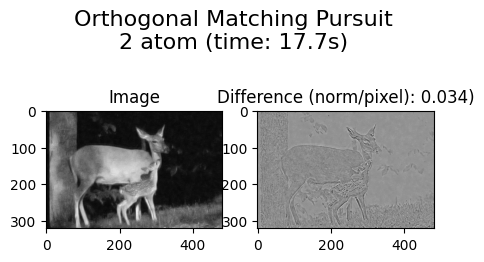

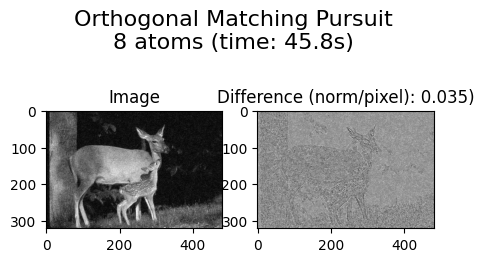

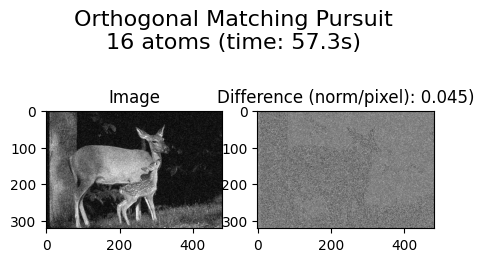

In [6]:
from utils import compute_metrics

print("Extracting noisy patches... ")
t0 = time()
data = extract_patches_2d(distorted, patch_size)
data = data.astype(np.float64)
data = data.reshape(data.shape[0], -1)
intercept = np.mean(data, axis=0)
data -= intercept

print("done in %.2fs." % (time() - t0))

im = Image.open("Figures/noisy_image0_noise_lvl25.jpg")
im_gray = np.array(im.convert('L'))

transform_algorithms = [
    ("Orthogonal Matching Pursuit\n2 atom", "omp", {"transform_n_nonzero_coefs": 2}),
    ("Orthogonal Matching Pursuit\n8 atoms", "omp", {"transform_n_nonzero_coefs": 8}),
    ("Orthogonal Matching Pursuit\n16 atoms", "omp", {"transform_n_nonzero_coefs": 16}),
]

reconstructions = {}
for title, transform_algorithm, kwargs in transform_algorithms:
    print(title + "...")
    reconstructions[title] = original.copy()
    t0 = time()
    dico.set_params(transform_algorithm=transform_algorithm, **kwargs)
    code = dico.transform(data)
    
    patches = np.dot(code, V)
    patches += intercept
    patches = patches.reshape(len(data), *patch_size)
    
    reconstructions[title] = reconstruct_from_patches_2d(
        patches, (height, width)
    )
    rmse, psnr = compute_metrics(original, reconstructions[title])
    print(f"done in %.2fs. RMSE: {rmse:.4f}, PSNR: {psnr:.4f} dB")
    dt = time() - t0
    print("done in %.2fs." % dt)
    show_with_diff(reconstructions[title], original, title + " (time: %.1fs)" % dt)

plt.show()

Extracting noisy patches... 
done in 0.06s.
Orthogonal Matching Pursuit
4 atoms...
done in 30.74s.


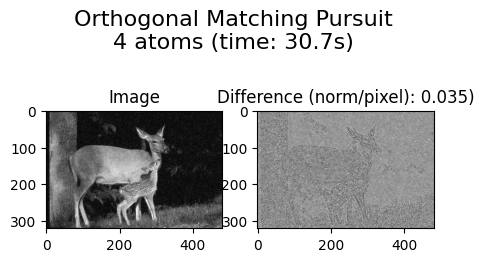

In [7]:
print("Extracting noisy patches... ")
t0 = time()
data = extract_patches_2d(distorted, patch_size)
data = data.astype(np.float64)
data = data.reshape(data.shape[0], -1)
intercept = np.mean(data, axis=0)
data -= intercept
print("done in %.2fs." % (time() - t0))

transform_algorithms = [
    ("Orthogonal Matching Pursuit\n4 atoms", "omp", {"transform_n_nonzero_coefs": 8}),
]

reconstructions = {}
for title, transform_algorithm, kwargs in transform_algorithms:
    print(title + "...")
    reconstructions[title] = original.copy()
    t0 = time()
    dico.set_params(transform_algorithm=transform_algorithm, **kwargs)
    code = dico.transform(data)
    patches = np.dot(code, V)

    patches += intercept
    patches = patches.reshape(len(data), *patch_size)
    
    reconstructions[title] = reconstruct_from_patches_2d(
        patches, (height, width)
    )
    dt = time() - t0
    print("done in %.2fs." % dt)
    show_with_diff(reconstructions[title], original, title + " (time: %.1fs)" % dt)

plt.show()

intercept.shape=(64,); results.shape=(4096, 64)
Orthogonal Matching Pursuit
4 atoms...
np.mean(reconstructed_image)=64.95827575448176
np.max(reconstructed_image)=313.8802914707687
np.min(reconstructed_image)=-52.028766587543956
np.std(reconstructed_image)=57.0014384005572
done in 1.03s.
Orthogonal Matching Pursuit
8 atoms...
np.mean(reconstructed_image)=65.02071793927335
np.max(reconstructed_image)=305.7898137058378
np.min(reconstructed_image)=-37.951440583196955
np.std(reconstructed_image)=57.967129857422286
done in 1.42s.
Orthogonal Matching Pursuit
16 atoms...
np.mean(reconstructed_image)=65.06131117901526
np.max(reconstructed_image)=295.5532232581262
np.min(reconstructed_image)=-36.463257673404826
np.std(reconstructed_image)=58.89168622182709
done in 1.65s.


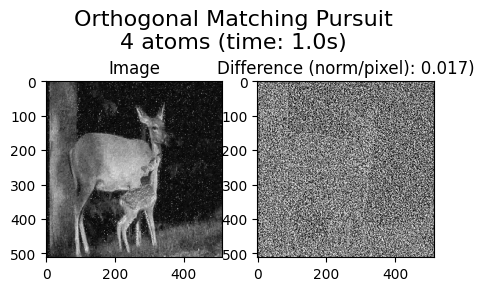

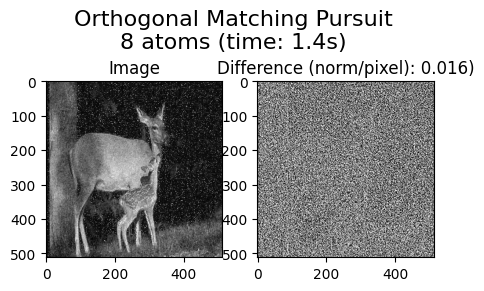

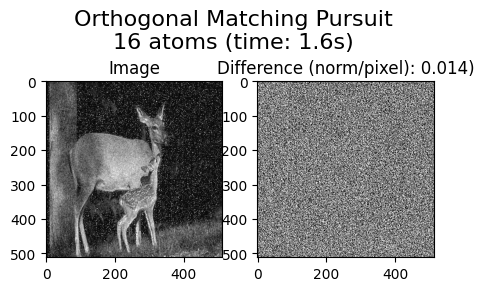

In [8]:
image = np.array(Image.open("Figures/noisy_image0_noise_lvl25.jpg").convert('L'))  # Convert to grayscale
im_gray = np.array(Image.open("Figures/noisy_image0_noise_lvl25.jpg").convert('L').resize((512, 512)))


im_gray_split = im_gray.copy()
results = view_as_blocks(im_gray_split, block_shape=patch_size)

results = results.astype(np.float64)
results = results.reshape(-1, 64)
intercept = np.mean(results, axis=0)

print(f"{intercept.shape=}; {results.shape=}")
results -= intercept

transform_algorithms = [
    ("Orthogonal Matching Pursuit\n4 atoms", "omp", {"transform_n_nonzero_coefs": 4}),
    ("Orthogonal Matching Pursuit\n8 atoms", "omp", {"transform_n_nonzero_coefs": 8}),
    ("Orthogonal Matching Pursuit\n16 atoms", "omp", {"transform_n_nonzero_coefs": 16}),
]

reconstructions = {}
for title, transform_algorithm, kwargs in transform_algorithms:
    print(title + "...")
    reconstructions[title] = original.copy()
    t0 = time()
    dico.set_params(transform_algorithm=transform_algorithm, **kwargs)
    code = dico.transform(results.reshape(-1,64))
    patches = np.dot(code, V)

    patches += intercept
    patches = patches.reshape(len(results), *patch_size)
    
    # Reshape the blocks into the original image shape
    reconstructed_image = reconstruct_image_from_patches(patches, image_size=(512, 512), patch_size=patch_size)
    print(f"{np.mean(reconstructed_image)=}")
    print(f"{np.max(reconstructed_image)=}")
    print(f"{np.min(reconstructed_image)=}")
    print(f"{np.std(reconstructed_image)=}")
    # Convert the reconstructed image to uint8 format
    reconstructed_image_uint8 = np.uint8(reconstructed_image)
   
    # Assign the reconstructed image to the dictionary
    reconstructions[title] = reconstructed_image_uint8
    dt = time() - t0
    print("done in %.2fs." % dt)
    show_with_diff(reconstructions[title], im_gray, title + " (time: %.1fs)" % dt)
